In [4]:
import os
import pickle
import glob
from os.path import join, exists
from os import listdir
from pathlib import Path

import numpy as np
import tensorflow as tf
import pandas as pd
import scipy.stats
from matplotlib import pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
%matplotlib notebook

In [2]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'TeX Gyre Heros'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['text.usetex'] = False
# import matplotlib.font_manager
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [3]:
# HOME_DIR = "/Users/carlo/Library/Group Containers/G69SCX94XU.duck/Library/Application Support/duck/Volumes/soder.carlorapisarda.me – SFTP/"
HOME_DIR = "/home/carlo/"

MS_THESIS_OUT_DIR = f"{HOME_DIR}/KTH/thesis/ms-thesis/out/"
DDPG_FORK_OUT_DIR = f"{HOME_DIR}/KTH/thesis/misc/hindsight-experience-replay/out/"
CACHE_DIR = f"{HOME_DIR}/KTH/thesis/ms-thesis/out/results_viz_cache/"
FIGURES_DIR = f"{HOME_DIR}/KTH/thesis/ms-thesis/figures/"
os.makedirs(CACHE_DIR, exist_ok=True)

REMOTE_HOME = "/run/user/1000/gvfs/sftp:host=mordor.csc.kth.se,port=2222,user=carlora/home/carlora/"
REMOTE_MS_THESIS_OUT_DIR = f"{REMOTE_HOME}/thesis/repo/out/"
REMOTE_DDPG_FORK_OUT_DIR = f"{REMOTE_HOME}/thesis/exp/hindsight-experience-replay/out"

In [5]:
def read_tensorboard_log(path):
    # Loading too much data is slow...
    tf_size_guidance = {
        'distributions': 1,
        'images': 0,
        'scalars': 1000,
        'histograms': 1,
        'tensors': 1000,
    }
    event_acc = EventAccumulator(path, tf_size_guidance)
    event_acc.Reload()
    return event_acc

def tb_scalar_to_numpy(event_acc, tag_name):
    scalar = event_acc.Scalars(tag_name)
    return np.array([x[2] for x in scalar])

def data_from_tensorboard_log(path):
    tf.logging.set_verbosity(tf.logging.ERROR)
    event_acc = read_tensorboard_log(path)
    scalar_tags = event_acc.Tags()['scalars']
    results = {}
    for tag in scalar_tags:
        results[tag] = tb_scalar_to_numpy(event_acc, tag)
    return results

def data_from_tensorboard_dir(exp_dir):
    results = {}
    for sub_dir in listdir(exp_dir):
        results[sub_dir] = data_from_tensorboard_log(join(exp_dir, sub_dir))
    return results

def cache_result(unique_name, data):
    with open(f'{CACHE_DIR}/{unique_name}.pkl', 'wb') as f:
        pickle.dump(data, f)
    globals()[unique_name] = data
    return data

def get_cached_result(unique_name):
    if unique_name in globals():
        return globals()[unique_name]
    else:
        p = Path(f'{CACHE_DIR}/{unique_name}.pkl')
        if not p.exists():
            return None
        with open(p, 'rb') as f:
            data = pickle.load(f)
        globals()[unique_name] = data
        return data

In [6]:
def read_sb_ppo2_experiment_data(exp_name, remote=False):
    if remote:
        exp_dir = f'{REMOTE_MS_THESIS_OUT_DIR}/ppo2/{exp_name}'
    else:
        exp_dir = f'{MS_THESIS_OUT_DIR}/ppo2/{exp_name}'
    results = {}
    for sub_dir in listdir(exp_dir):
        sub_dir_p = join(exp_dir, sub_dir)
        for tb_dir in listdir(sub_dir_p):
            if 'tb' not in tb_dir:
                continue
            results[sub_dir] = data_from_tensorboard_log(join(sub_dir_p, tb_dir))
    return results

In [8]:
def read_her_torch_experiment_data(exp_name, remote=False):
    if remote:
        exp_dir = f'{REMOTE_DDPG_FORK_OUT_DIR}/her_torch/{exp_name}'
    else:
        exp_dir = f'{DDPG_FORK_OUT_DIR}/her_torch/{exp_name}'
    csvs = glob.glob(f'{exp_dir}/*/progress.csv')
    results = {}
    for c in csvs:
        c = Path(c)
        results[c.parent.name] = pd.read_csv(c)
    return results

# Preliminary Experiments

### Fetch (sparse reward) with DDPG+HER

/Users/carlo/Documents/Stockholm/KTH/Courses/PCDS/pcds_env/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


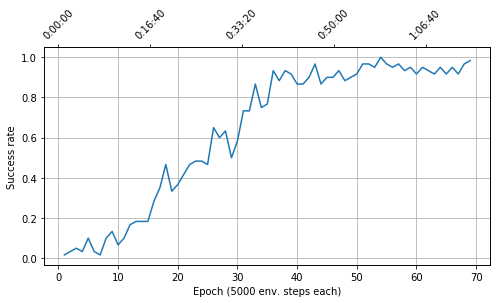

In [7]:
def _plot():
    from datetime import timedelta
    import matplotlib.ticker as ticker
    
    result_id = '_fetch_sparse_ddpg_her_baseline_new_local_res'
    data = get_cached_result(result_id)
    if data is None:
        data = read_her_torch_experiment_data('fetch_weighted_her/baseline_new')
        cache_result(result_id, data)
    
    df = list(data.values())[0]
    success_rate = df['test_success_rate'].values
    steps_per_epoch = df['env_steps'][0]

    fig = plt.figure(figsize=(8,4))
    ax1 = fig.gca()
    ax1.plot(df['training_iteration'].values, success_rate)
    ax1.set_ylabel('Success rate')
    ax1.set_xlabel('Epoch ({} env. steps each)'.format(steps_per_epoch))

    ax2 = ax1.twiny()
    ax2.plot(df['total_time'].values, success_rate).pop(0).remove()

    def _format_date(x, pos=None):
        return str(timedelta(seconds=x))

    ax2.xaxis.set_major_formatter(ticker.FuncFormatter(_format_date))
    for tick in ax2.get_xticklabels():
        tick.set_rotation(45)
        
    ax1.grid()

_plot()
plt.show()
# plt.savefig(f'{FIGURES_DIR}/fetch_sparse_her_torch.pdf', bbox_inches='tight')

### Fetch (stepped reward) with SB PPO2

In [188]:
def _plot():
    from datetime import timedelta
    import matplotlib.ticker as ticker

    result_id = '_fetch_stepped_rew_v3_ppo2_remote_res'
    data = get_cached_result(result_id)
    if data is None:
        data = read_sb_ppo2_experiment_data('fetch_stepped_rew_v3', remote=True)
        cache_result(result_id, data)

    data_dict = list(data.values())[0]
    success_rate = data_dict['custom/original_success_rate']
    steps_per_epoch = '?' # data_dict['env_steps'][0]

    fig = plt.figure(figsize=(8,4))
    ax1 = fig.gca()
    ax1.plot(success_rate)
    ax1.set_ylabel('Success rate')
    ax1.set_xlabel('Epoch ({} env. steps each)'.format(steps_per_epoch))

#     ax2 = ax1.twiny()
#     ax2.plot(df['total_time'].values, success_rate).pop(0).remove()

#     def _format_date(x, pos=None):
#         return str(timedelta(seconds=x))

#     ax2.xaxis.set_major_formatter(ticker.FuncFormatter(_format_date))
#     for tick in ax2.get_xticklabels():
#         tick.set_rotation(45)

    ax1.grid()

_plot()
# plt.show()
plt.savefig(f'{FIGURES_DIR}/fetch_stepped_sb_ppo2.pdf', bbox_inches='tight')

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


In [89]:
list(_fetch_stepped_rew_v3_ppo2_remote_res.values())[0].keys()

dict_keys(['loss/entropy_loss', 'loss/policy_gradient_loss', 'loss/value_function_loss', 'loss/approximate_kullback-leiber', 'loss/clip_factor', 'loss/loss', 'input_info/discounted_rewards', 'input_info/learning_rate', 'input_info/advantage', 'input_info/clip_range', 'input_info/old_neglog_action_probabilty', 'input_info/old_value_pred', 'episode_reward', 'custom/original_episode_reward', 'custom/original_success_rate'])

## YuMi Constrained (v2) DDPG+HER

In [184]:
def _plot():
    from datetime import timedelta
    import matplotlib.ticker as ticker
    
    result_id = '_yumi_constr_v2_sparse_ddpg_her_local_res'
    data = get_cached_result(result_id)
    if data is None:
        data = read_her_torch_experiment_data('yumi_constrained_v2')
        cache_result(result_id, data)
        
    print(data.keys())
    df = list(data.values())[0]
    success_rate = df['test_success_rate'].values
    steps_per_epoch = df['env_steps'][0]

    fig = plt.figure(figsize=(8,4))
    ax1 = fig.gca()
    ax1.plot(df['training_iteration'].values, success_rate)
    ax1.set_ylabel('Success rate')
    ax1.set_xlabel('Epoch ({} env. steps each)'.format(steps_per_epoch))

    ax2 = ax1.twiny()
    ax2.plot(df['total_time'].values, success_rate).pop(0).remove()

    def _format_date(x, pos=None):
        return str(timedelta(seconds=x))

    ax2.xaxis.set_major_formatter(ticker.FuncFormatter(_format_date))
    for tick in ax2.get_xticklabels():
        tick.set_rotation(45)
        
    ax1.grid()

_plot()
# plt.show()
plt.savefig(f'{FIGURES_DIR}/yumi_constr_sparse_her_torch.pdf', bbox_inches='tight')

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


dict_keys(['2019-05-10_00-30-08', '2019-05-09_10-29-40'])


'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


## Shadow Hand PP DDPG+HER

dict_keys(['2019-03-01_13-14-33'])


<IPython.core.display.Javascript object>


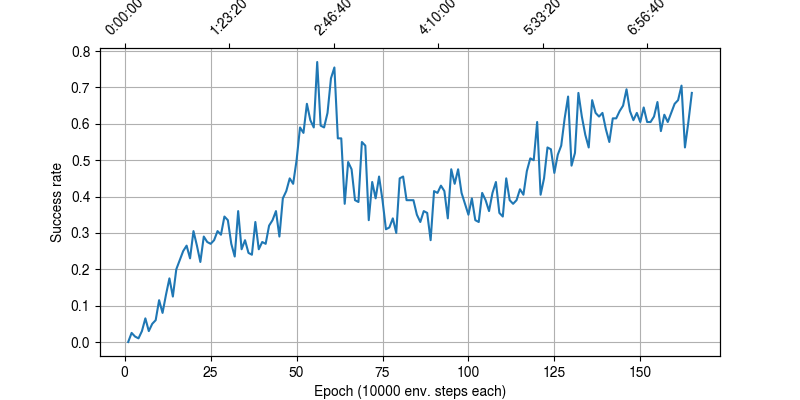

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


In [16]:
def _plot():
    from datetime import timedelta
    import matplotlib.ticker as ticker
    
    result_id = '_hand_pp_sparse_ddpg_her_remote_res'
    data = get_cached_result(result_id)
    # data = None
    
    if data is None:
        data = read_her_torch_experiment_data('hand_pp_parallel_arm_grasp_init', remote=True)
        cache_result(result_id, data)
        
    print(data.keys())
    df = list(data.values())[0]
    success_rate = df['test_success_rate'].values
    steps_per_epoch = df['env_steps'][0]

    fig = plt.figure(figsize=(8,4))
    ax1 = fig.gca()
    ax1.plot(df['training_iteration'].values, success_rate)
    ax1.set_ylabel('Success rate')
    ax1.set_xlabel('Epoch ({} env. steps each)'.format(steps_per_epoch))

    ax2 = ax1.twiny()
    ax2.plot(df['total_time'].values, success_rate).pop(0).remove()

    def _format_date(x, pos=None):
        return str(timedelta(seconds=x))

    ax2.xaxis.set_major_formatter(ticker.FuncFormatter(_format_date))
    for tick in ax2.get_xticklabels():
        tick.set_rotation(45)
        
    ax1.grid()

_plot()
plt.savefig(f'{FIGURES_DIR}/hand_pp_sparse_her_torch.pdf', bbox_inches='tight')

# Experiments

## Performance after alignment: Fetch to YuMi

dict_keys(['progress/cycle', 'progress/epoch', 'training_loss/avg_total', 'training_loss/avg_a_loss', 'training_loss/avg_b_loss', 'training_loss/avg_sim_loss', 'training_loss/avg_a_kdl_loss', 'training_loss/avg_b_kdl_loss', 'training_loss/avg_a_recon_loss', 'training_loss/avg_b_recon_loss', 'test_loss/avg_total', 'test_loss/avg_a_loss', 'test_loss/avg_b_loss', 'test_loss/avg_sim_loss', 'test_loss/avg_a_kdl_loss', 'test_loss/avg_b_kdl_loss', 'test_loss/avg_a_recon_loss', 'test_loss/avg_b_recon_loss', 'imitation_success_rate'])


<IPython.core.display.Javascript object>


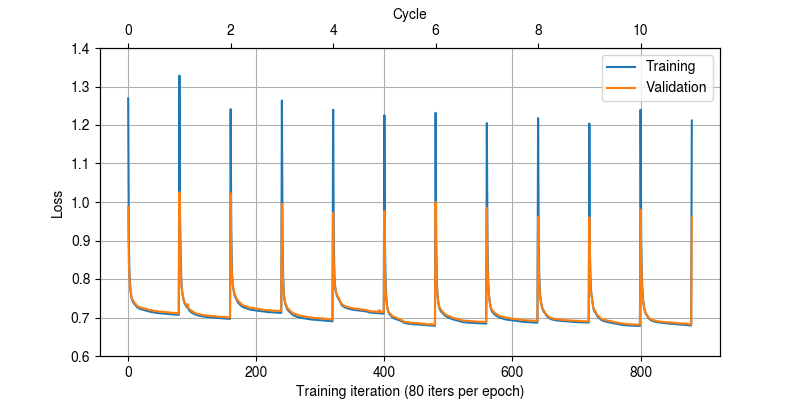

In [24]:
def _plot():
    from datetime import timedelta
    import matplotlib.ticker as ticker
    
    result_id = '_twin_yumi_v2_fetch_ae_resets_ext_bounds2'
    data = get_cached_result(result_id)
    if data is None:
        data = data_from_tensorboard_log(join(MS_THESIS_OUT_DIR, 'twin_yumi_v2_fetch_ae_resets_ext_bounds2'))
        cache_result(result_id, data)
        
    print(data.keys())
    training_loss = data['training_loss/avg_total']
    test_loss = data['test_loss/avg_total']
    im_success_rate = data['imitation_success_rate']
    epochs_per_cycle = int(data['progress/epoch'].max()) + 1

    fig = plt.figure(figsize=(8,4))
    ax1 = fig.gca()
    ax1.plot(training_loss, label='Training')
    ax1.plot(test_loss, label='Validation')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel(f'Training iteration ({epochs_per_cycle} iters per epoch)')
    
    ax2 = ax1.twiny()
    ax2.plot(np.arange(len(test_loss)) / epochs_per_cycle, np.zeros(len(test_loss))).pop(0).remove()
    ax2.set_xlabel('Cycle')
    ax1.set_ylim(0.6, 1.4)
        
    ax1.grid()
    ax1.legend()

_plot()
# plt.savefig(f'{FIGURES_DIR}/ae_fetch_to_yumi_losses.pdf', bbox_inches='tight')

dict_keys(['progress/cycle', 'progress/epoch', 'training_loss/avg_total', 'training_loss/avg_a_loss', 'training_loss/avg_b_loss', 'training_loss/avg_sim_loss', 'training_loss/avg_a_kdl_loss', 'training_loss/avg_b_kdl_loss', 'training_loss/avg_a_recon_loss', 'training_loss/avg_b_recon_loss', 'test_loss/avg_total', 'test_loss/avg_a_loss', 'test_loss/avg_b_loss', 'test_loss/avg_sim_loss', 'test_loss/avg_a_kdl_loss', 'test_loss/avg_b_kdl_loss', 'test_loss/avg_a_recon_loss', 'test_loss/avg_b_recon_loss', 'imitation_success_rate'])


<IPython.core.display.Javascript object>


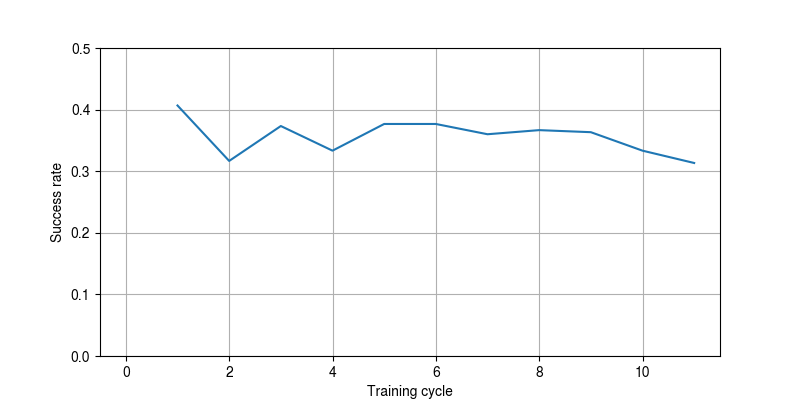

In [26]:
def _plot():
    from datetime import timedelta
    import matplotlib.ticker as ticker
    
    result_id = '_twin_yumi_v2_fetch_ae_resets_ext_bounds2'
    data = get_cached_result(result_id)
    if data is None:
        data = data_from_tensorboard_log(join(MS_THESIS_OUT_DIR, 'twin_yumi_v2_fetch_ae_resets_ext_bounds2'))
        cache_result(result_id, data)
        
    print(data.keys())
    im_success_rate = data['imitation_success_rate']
    x = data['progress/cycle'] * data['progress/epoch'].max()

    fig = plt.figure(figsize=(8,4))
    ax1 = fig.gca()
    ax1.plot(np.arange(len(im_success_rate))+1, im_success_rate, label='im_success_rate')
    ax1.set_ylabel('Success rate')
    ax1.set_xlabel('Training cycle')
    ax1.set_ylim(0.0, 0.5)
    ax1.set_xlim(-0.5, 11.5)

    ax1.grid()

_plot()
# plt.savefig(f'{FIGURES_DIR}/ae_fetch_to_yumi_im_succ_rate.pdf', bbox_inches='tight')

In [47]:
plt.show()

## Transfer: Fetch to YuMi (target_task: push)

dict_keys(['2019-05-21_11-50-41'])


<IPython.core.display.Javascript object>


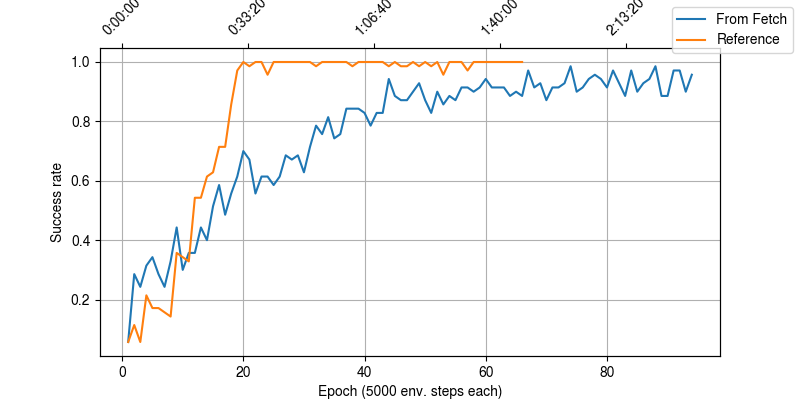

In [21]:
def _plot():
    from datetime import timedelta
    import matplotlib.ticker as ticker
    
    result_id_im = '_her_local_res_yumi_im_from_fetch_push'
    data_im = get_cached_result(result_id_im)
    if data_im is None:
        data_im = read_her_torch_experiment_data('yumi_im_from_fetch_push')
        cache_result(result_id_im, data_im)
    
    result_id_ref = '_her_local_res_yumi_ref_push'
    data_ref = get_cached_result(result_id_ref)
    if data_ref is None:
        data_ref = read_her_torch_experiment_data('yumi_constr_push')
        cache_result(result_id_ref, data_ref)
        
    print(data_im.keys())
    df = list(data_im.values())[0]
    df_ref = list(data_ref.values())[0]
    success_rate = df['test_success_rate'].values
    steps_per_epoch = df['env_steps'][0]

    fig = plt.figure(figsize=(8,4))
    ax1 = fig.gca()
    
    ax1.plot(df['training_iteration'].values, success_rate, label='From Fetch')
    ax1.plot(df_ref['training_iteration'].values, df_ref['test_success_rate'].values, label='Reference')
    
    ax1.set_ylabel('Success rate')
    ax1.set_xlabel('Epoch ({} env. steps each)'.format(steps_per_epoch))

    ax2 = ax1.twiny()
    ax2.plot(df['total_time'].values, success_rate).pop(0).remove()

    def _format_date(x, pos=None):
        return str(timedelta(seconds=x))

    ax2.xaxis.set_major_formatter(ticker.FuncFormatter(_format_date))
    for tick in ax2.get_xticklabels():
        tick.set_rotation(45)
        
    ax1.grid()
    fig.legend()

_plot()
# plt.savefig(f'{FIGURES_DIR}/yumi_im_fetch_push_vs_ref_her.pdf', bbox_inches='tight')

## Transfer: Fetch to YuMi (target_task: push w/ button)

dict_keys(['2019-05-23_14-53-10'])


<IPython.core.display.Javascript object>


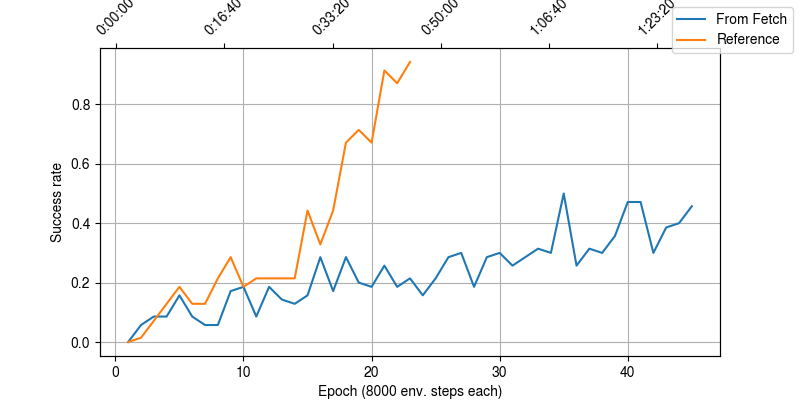

In [22]:
def _plot():
    from datetime import timedelta
    import matplotlib.ticker as ticker
    
    result_id_im = '_her_local_res_yumi_im_from_fetch_push_button'
    data_im = get_cached_result(result_id_im)
    if data_im is None:
        data_im = read_her_torch_experiment_data('yumi_im_from_fetch_push_button')
        cache_result(result_id_im, data_im)
    
    result_id_ref = '_her_local_res_yumi_ref_push_button'
    data_ref = get_cached_result(result_id_ref)
    if data_ref is None:
        data_ref = read_her_torch_experiment_data('yumi_constr_push_button')
        cache_result(result_id_ref, data_ref)
        
    print(data_im.keys())
    df = list(data_im.values())[0]
    df_ref = list(data_ref.values())[0]
    success_rate = df['test_success_rate'].values
    steps_per_epoch = df['env_steps'][0]

    fig = plt.figure(figsize=(8,4))
    ax1 = fig.gca()
    
    ax1.plot(df['training_iteration'].values, success_rate, label='From Fetch')
    ax1.plot(df_ref['training_iteration'].values, df_ref['test_success_rate'].values, label='Reference')
    
    ax1.set_ylabel('Success rate')
    ax1.set_xlabel('Epoch ({} env. steps each)'.format(steps_per_epoch))

    ax2 = ax1.twiny()
    ax2.plot(df['total_time'].values, success_rate).pop(0).remove()

    def _format_date(x, pos=None):
        return str(timedelta(seconds=x))

    ax2.xaxis.set_major_formatter(ticker.FuncFormatter(_format_date))
    for tick in ax2.get_xticklabels():
        tick.set_rotation(45)
        
    ax1.grid()
    fig.legend()

_plot()
# plt.savefig(f'{FIGURES_DIR}/yumi_im_fetch_push_btn_vs_ref_her.pdf', bbox_inches='tight')

## Transfer: Fetch to YuMi (target_task: push sphere)

dict_keys(['2019-05-31_14-32-26'])


<IPython.core.display.Javascript object>


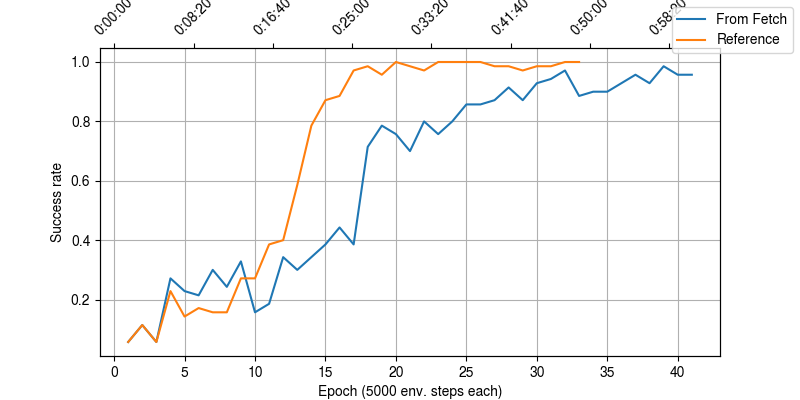

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


In [32]:
def _plot():
    from datetime import timedelta
    import matplotlib.ticker as ticker
    
    result_id_im = '_her_local_res_yumi_im_from_fetch_push_sphere'
    data_im = get_cached_result(result_id_im)
    data_im = None
    
    if data_im is None:
        data_im = read_her_torch_experiment_data('yumi_constr_push_sphere_im_from_fetch')
        cache_result(result_id_im, data_im)
    
    result_id_ref = '_her_local_res_yumi_ref_push_sphere'
    data_ref = get_cached_result(result_id_ref)
    data_ref = None
    
    if data_ref is None:
        data_ref = read_her_torch_experiment_data('yumi_constr_push_sphere_ref')
        cache_result(result_id_ref, data_ref)
        
    print(data_im.keys())
    df = list(data_im.values())[0]
    df_ref = list(data_ref.values())[0]
    success_rate = df['test_success_rate'].values
    steps_per_epoch = df['env_steps'][0]

    fig = plt.figure(figsize=(8,4))
    ax1 = fig.gca()
    
    ax1.plot(df['training_iteration'].values, success_rate, label='From Fetch')
    ax1.plot(df_ref['training_iteration'].values, df_ref['test_success_rate'].values, label='Reference')
    
    ax1.set_ylabel('Success rate')
    ax1.set_xlabel('Epoch ({} env. steps each)'.format(steps_per_epoch))

    ax2 = ax1.twiny()
    ax2.plot(df['total_time'].values, success_rate).pop(0).remove()

    def _format_date(x, pos=None):
        return str(timedelta(seconds=x))

    ax2.xaxis.set_major_formatter(ticker.FuncFormatter(_format_date))
    for tick in ax2.get_xticklabels():
        tick.set_rotation(45)
        
    ax1.grid()
    fig.legend()

_plot()
plt.savefig(f'{FIGURES_DIR}/yumi_im_fetch_push_sphere_vs_ref_her.pdf', bbox_inches='tight')